# YouTube Adview Prediction using Machine Learning Models
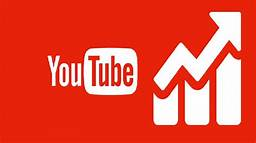
## Overview

The goal of this project is to build predictive models to estimate the number of adviews a YouTube video will receive based on various features. The dataset used for this prediction includes features such as views, likes, dislikes, comments, and video categories. The models trained and evaluated in this project include Linear Regression, Decision Tree Regressor, and Random Forest Regressor.

## Dataset

The dataset, `train.csv`, contains historical data on YouTube videos, including:
- `views`: The number of views a video has received.
- `likes`: The number of likes a video has received.
- `dislikes`: The number of dislikes a video has received.
- `comment`: The number of comments on a video.
- `adview`: The target variable indicating the number of adviews.
- `category`: The category of the video.
- `vidid`: A unique identifier for the video.
- `published`: The publication date of the video.


## 1.Import Libraries
Various Python libraries are imported here. `numpy` and `pandas` are used for numerical operations and data manipulation. `seaborn` and `matplotlib` are for visualization, while `scipy` provides statistical functions. `sklearn` libraries are used for machine learning tasks, including preprocessing, model training, and evaluation. `joblib` is used for saving the trained models.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## 2. Load the dataset
The dataset is loaded from a CSV file into a pandas DataFrame. The `head(8)` function displays the first 8 rows of the dataset, allowing you to get an initial view of the data structure and contents.

In [44]:
data_train = pd.read_csv("train.csv")
data_train.head(8)

,vidid,adview,views,likes,dislikes,comment,published,Duration,category
0,VID_18655,40,1031602,8523,363,1095,9/14/2016,457,F
1,VID_14135,2,1707,56,2,6,10/1/2016,570,D
2,VID_2187,1,2023,25,0,2,7/2/2016,136,C
3,VID_23096,6,620860,777,161,153,7/27/2016,262,H
4,VID_10175,1,666,1,0,0,6/29/2016,31,D
5,VID_10756,4,78,0,0,0,5/9/2016,15,D
6,VID_9782,40621,43118,15,1,0,8/21/2015,200,D
7,VID_16452,1,14205,55,16,1,8/1/2016,58,E


## 3. Initial Data Preprocessing
 ### 3.1. Remove outliers
To ensure the quality of the data, outliers are removed from the `adview` column. Any value greater than 2,000,000 is considered an outlier and is filtered out to prevent skewing the model.

In [45]:
data_train = data_train[data_train["adview"] < 2000000]

### 3.2. Remove rows with 'F' values
This step removes rows where any of the columns `views`, `likes`, `dislikes`, or `comment` have the value 'F'. Such values are likely erroneous or missing and can adversely affect the model's performance.

In [46]:
data_train = data_train[(data_train.views != 'F') & (data_train.likes != 'F') & 
                        (data_train.dislikes != 'F') & (data_train.comment != 'F')]

### 3.3. Convert columns to numeric values
The columns `views`, `likes`, `dislikes`, `comment`, and `adview` are converted to numeric values to facilitate mathematical operations. This step ensures that all relevant columns are in the appropriate format for analysis and modeling.

In [47]:
data_train["views"] = pd.to_numeric(data_train["views"])
data_train["likes"] = pd.to_numeric(data_train["likes"])
data_train["dislikes"] = pd.to_numeric(data_train["dislikes"])
data_train["comment"] = pd.to_numeric(data_train["comment"])
data_train["adview"] = pd.to_numeric(data_train["adview"])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14636 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vidid      14636 non-null  object
 1   adview     14636 non-null  int64 
 2   views      14636 non-null  int64 
 3   likes      14636 non-null  int64 
 4   dislikes   14636 non-null  int64 
 5   comment    14636 non-null  int64 
 6   published  14636 non-null  object
 7   Duration   14636 non-null  int64 
 8   category   14636 non-null  object
dtypes: int64(6), object(3)
memory usage: 1.1+ MB


### 3.4. Assign numerical values to categories
The `category` column contains categorical values that are mapped to numerical values using a predefined dictionary. This encoding transforms categorical data into a format suitable for machine learning algorithms.

In [48]:
category_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
data_train["category"] = data_train["category"].map(category_mapping)

### 3.5. Label Encoding for categorical features
The `LabelEncoder` is used to convert categorical text data in the `vidid` and `published` columns into numerical format. This is essential for models that require numeric input features.

In [49]:
label_enc = LabelEncoder()
data_train['vidid'] = label_enc.fit_transform(data_train['vidid'])
data_train['published'] = label_enc.fit_transform(data_train['published'])
data_train.head()

,vidid,adview,views,likes,dislikes,comment,published,Duration,category
0,5912,40,1031602,8523,363,1095,2235,457,6
1,2741,2,1707,56,2,6,207,570,4
2,8138,1,2023,25,0,2,1905,136,3
3,9004,6,620860,777,161,153,1952,262,8
4,122,1,666,1,0,0,1783,31,4


## 4. Correlation Matrix

A heatmap of the feature correlation matrix is created to visualize relationships between features. It uses color-coded coefficients to illustrate how strongly features are correlated with each other, helping to identify significant correlations and potential multicollinearity issues.

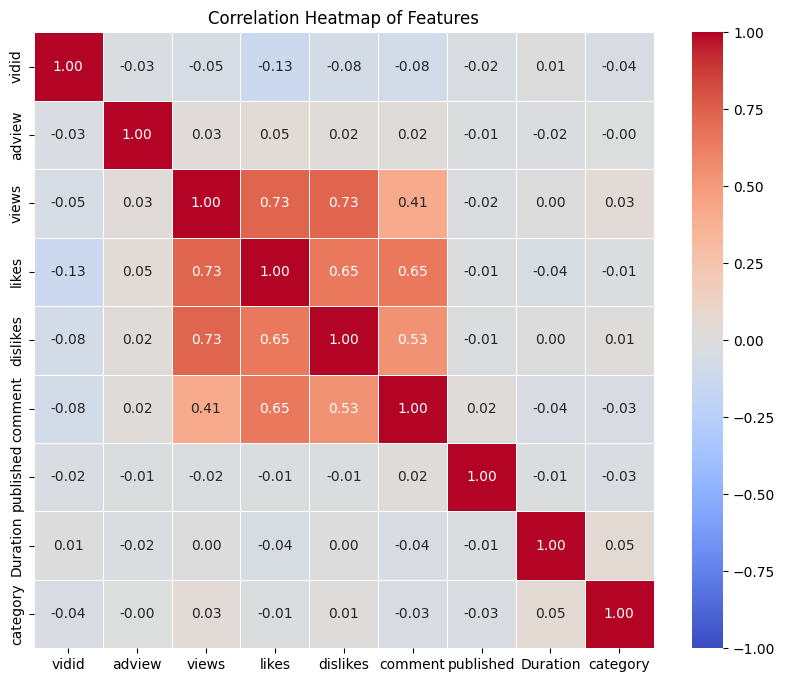

In [50]:
# Compute the correlation matrix
correlation_matrix = data_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Title and labels
plt.title('Correlation Heatmap of Features')
plt.show()

## 5. Split Data
The dataset is split into features (`X`) and target variable (`y`). The `adview` column is separated as the target variable. The data is then divided into training and testing sets, with 20% of the data used for testing. The `random_state` parameter ensures that the split is reproducible.

In [51]:
X = data_train.drop(["adview"], axis=1)
y = data_train["adview"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Normalization
Feature scaling is performed using `MinMaxScaler`, which normalizes the feature values to a range between 0 and 1. This step helps in improving the performance and convergence of many machine learning algorithms.

In [52]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 7. Define error printing function
The `print_error` function calculates and prints three common error metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). These metrics help in assessing the performance of the model by comparing the predicted values to the actual values.

In [53]:
def print_error(X_test, y_test, model):
    prediction = model.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, prediction))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, prediction))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

## 8. Train and Evaluate Models

### 8.1. Train a Linear Regression model
A Linear Regression model is trained using the training data and evaluated using the testing data. The `print_error` function is used to display the error metrics, providing insight into the model's performance.

In [54]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)
print("Linear Regression Error Metrics:")
print_error(X_test, y_test, linear_regression)

Linear Regression Error Metrics:
Mean Absolute Error: 3304.7033468863856
Mean Squared Error: 832823423.2444199
Root Mean Squared Error: 28858.68020621213


#### 8.1.1 Line Plot and QQ Plot for Linear Regression
A line plot is created to compare the actual and predicted adviews for the Linear Regression model. This visualization helps in understanding how well the model's predictions align with the actual values. Additionally, a QQ plot is generated to assess the normality of the residuals (errors), which is an important assumption for Linear Regression.

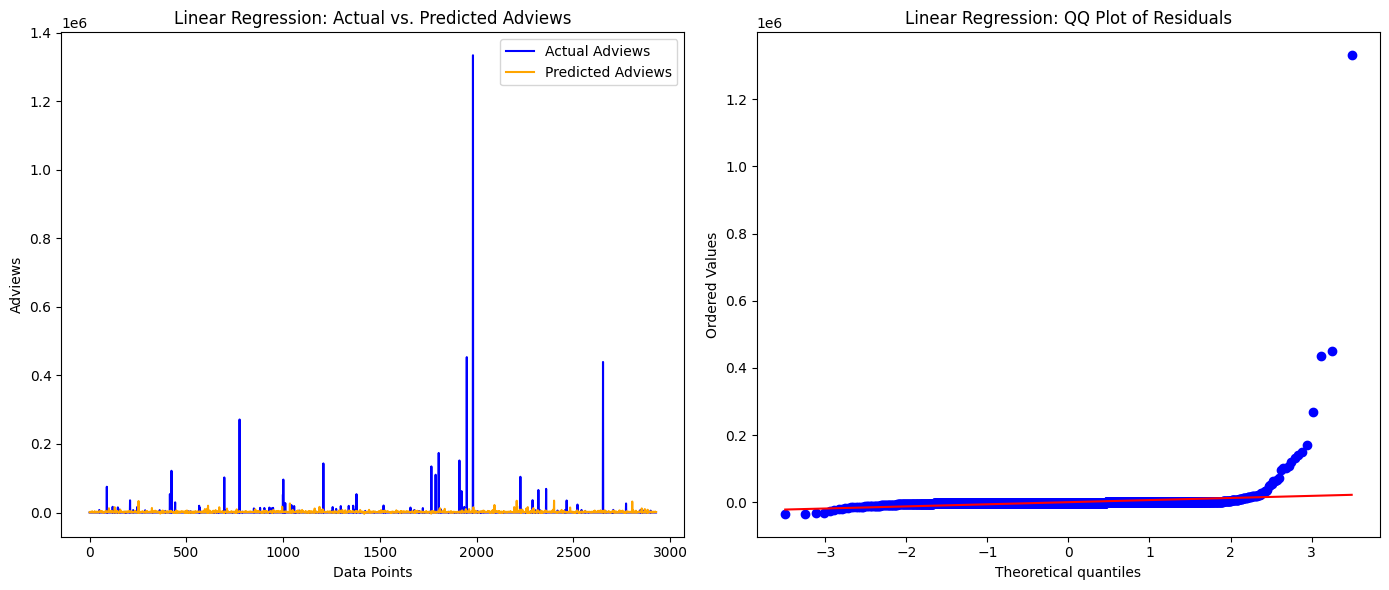

In [55]:
# Predict adviews using Linear Regression
y_pred_lr = linear_regression.predict(X_test)

# Calculate residuals
residuals_lr = y_test - y_pred_lr

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Line plot for actual vs. predicted adviews
ax[0].plot(y_test.values, label='Actual Adviews', color='blue')
ax[0].plot(y_pred_lr, label='Predicted Adviews', color='orange')
ax[0].set_xlabel('Data Points')
ax[0].set_ylabel('Adviews')
ax[0].set_title('Linear Regression: Actual vs. Predicted Adviews')
ax[0].legend()

# QQ plot of residuals for Linear Regression
stats.probplot(residuals_lr, dist="norm", plot=ax[1])
ax[1].set_title('Linear Regression: QQ Plot of Residuals')
ax[1].set_ylabel('Ordered Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### 8.2. Decision Tree Regressor
A Decision Tree Regressor is trained and evaluated similarly to the Linear Regression model. The `print_error` function displays the performance metrics, which helps in comparing the Decision Tree Regressor's performance against other models.

In [56]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
print("\nDecision Tree Error Metrics:")
print_error(X_test, y_test, decision_tree)


Decision Tree Error Metrics:
Mean Absolute Error: 3512.405054644809
Mean Squared Error: 1733445799.9173498
Root Mean Squared Error: 41634.67064739854


#### 8.2.1 Line Plot and QQ Plot for Decision Tree Regressor
The line plot and QQ plot for the Decision Tree Regressor provide visualizations for comparing the actual and predicted adviews, as well as assessing the distribution of residuals. These plots are useful for diagnosing model performance and error characteristics.

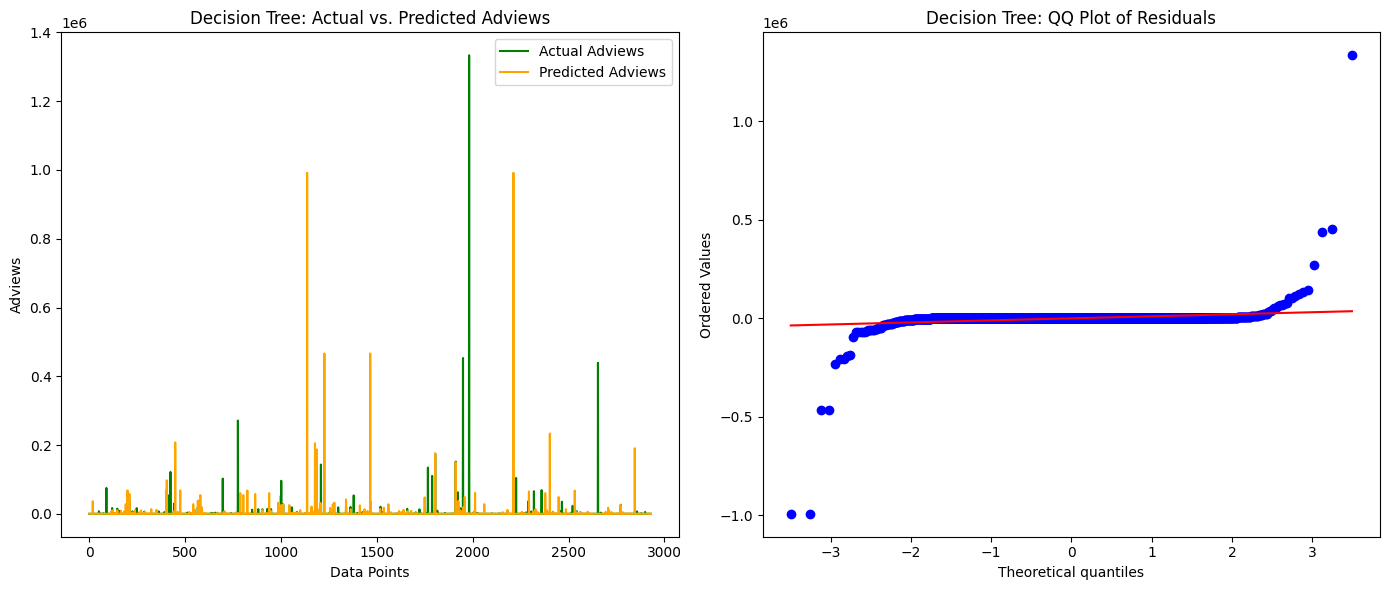

In [57]:
# Predict adviews using Decision Tree
y_pred_dt = decision_tree.predict(X_test)

# Calculate residuals
residuals_dt = y_test - y_pred_dt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Line plot for actual vs. predicted adviews using Decision Tree
ax[0].plot(y_test.values, label='Actual Adviews', color='green')
ax[0].plot(y_pred_dt, label='Predicted Adviews', color='orange')
ax[0].set_xlabel('Data Points')
ax[0].set_ylabel('Adviews')
ax[0].set_title('Decision Tree: Actual vs. Predicted Adviews')
ax[0].legend()

# QQ plot of residuals for Decision Tree
stats.probplot(residuals_dt, dist="norm", plot=ax[1])
ax[1].set_title('Decision Tree: QQ Plot of Residuals')
ax[1].set_ylabel('Ordered Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### 8.3. Random Forest Regressor
A Random Forest Regressor is trained with specified hyperparameters such as the number of trees (`n_estimators`), maximum depth of the trees (`max_depth`), minimum samples required to split an internal node (`min_samples_split`), and minimum samples required to be at a leaf node (`min_samples_leaf`). The model is evaluated to compare its performance with the other models.

In [62]:
random_forest = RandomForestRegressor(n_estimators=200, max_depth=25, min_samples_split=15, min_samples_leaf=2)
random_forest.fit(X_train, y_train)
print("\nRandom Forest Error Metrics:")
print_error(X_test, y_test, random_forest)


Random Forest Error Metrics:
Mean Absolute Error: 2958.139366247811
Mean Squared Error: 781477366.6139175
Root Mean Squared Error: 27954.916680503942


#### 8.3.1 Line Plot and QQ Plot for Random Forest Regressor
Line Plot: Compares the actual adviews (purple) with the predicted values (orange) from the Random Forest Regressor. This helps visualize how closely the model's predictions align with the actual values.

QQ Plot: Shows the distribution of residuals (errors) to assess if they follow a normal distribution. A good fit will have points that lie along the reference line, indicating well-distributed errors.

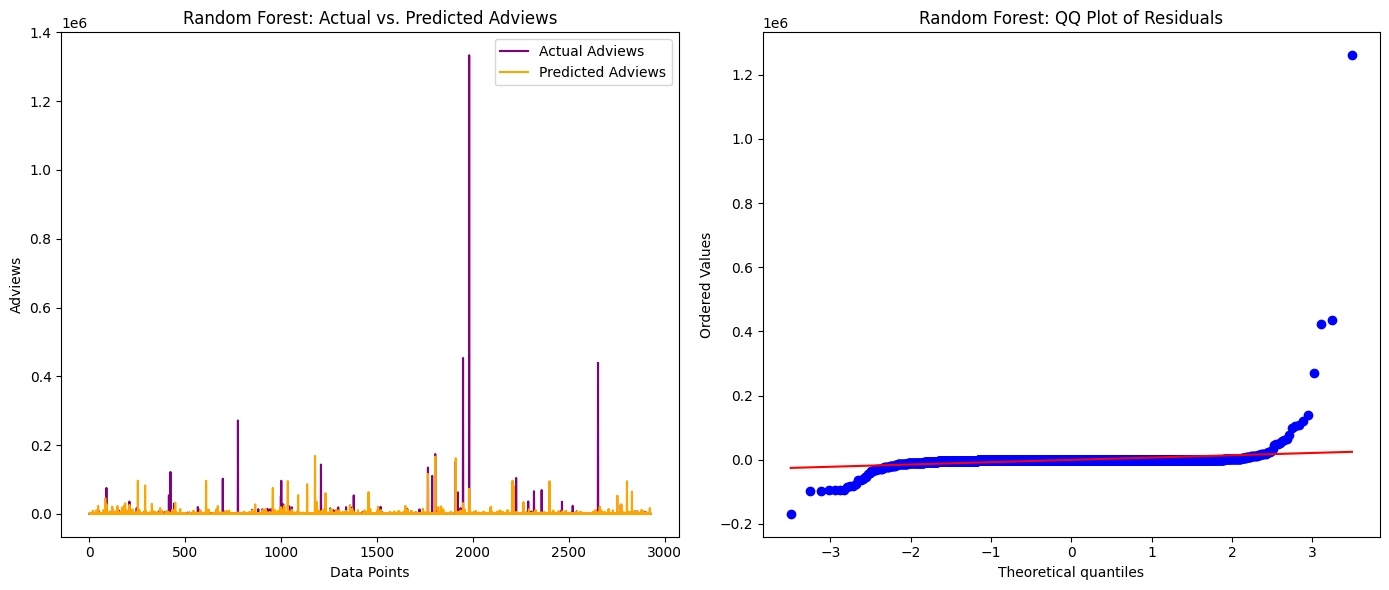

In [63]:
# Predict adviews using Random Forest
y_pred_rf = random_forest.predict(X_test)

# Calculate residuals
residuals_rf = y_test - y_pred_rf

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Line plot for actual vs. predicted adviews using Random Forest
ax[0].plot(y_test.values, label='Actual Adviews', color='purple')
ax[0].plot(y_pred_rf, label='Predicted Adviews', color='orange')
ax[0].set_xlabel('Data Points')
ax[0].set_ylabel('Adviews')
ax[0].set_title('Random Forest: Actual vs. Predicted Adviews')
ax[0].legend()

# QQ plot of residuals for Random Forest
stats.probplot(residuals_rf, dist="norm", plot=ax[1])
ax[1].set_title('Random Forest: QQ Plot of Residuals')
ax[1].set_ylabel('Ordered Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 9. Saving Decision Tree Model
The trained Decision Tree Regressor model is saved to a file named `decisiontree_youtubeadview.pkl` using `joblib`. This serialized file can be easily loaded in the future for predictions or further analysis without needing to retrain the model. Saving models allows you to preserve the state of the model and reuse it efficiently.

In [60]:
joblib.dump(decision_tree, "decisiontree_youtubeadview.pkl")

['decisiontree_youtubeadview.pkl']

## 10. Saving Random Forest Model
Similarly, the trained Random Forest Regressor model is saved to a file named `randomforest_youtubeadview.pkl` using `joblib`. This step ensures that the Random Forest model is stored in a serialized format that can be reloaded later, facilitating model deployment or continued experimentation without retraining.

In [61]:
joblib.dump(random_forest, "randomforest_youtubeadview.pkl")

['randomforest_youtubeadview.pkl']

## Summary

This project demonstrates the process of predicting YouTube adviews using various regression models. It involves data preprocessing, model training, evaluation, and visualization to assess and improve model performance. The chosen models are Linear Regression, Decision Tree Regressor, and Random Forest Regressor, each providing different insights and performance metrics for predicting adviews.